# CSE144 Final Project
Group Members: Russell Elliott, Neil Grover

In [22]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision.models as models

In [23]:
# #Training Data
# X = torch.load('train_data.pth')
# y = torch.load('train_labels.pth') 

# X = X.permute(0, 3, 1, 2)

# print(X.shape)
# print(y.shape)

# #Make a model for training on the train data via a validation set. From there, we'll test our model via the test set
# # Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [24]:
# # Fix seed
# def set_seed(seed):
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)

# set_seed(42)

In [25]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split
from PIL import Image

class CustomImageFolder(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform

        # Get the list of subfolders (folder names are strings)
        subfolders = sorted(os.listdir(self.root), key=lambda x: int(x))

        # Create a list of paths to the subfolders in numerical order
        subfolders_paths = [os.path.join(self.root, folder) for folder in subfolders]

        # Initialize lists to store image paths and labels
        self.samples = []

        for class_idx, folder_path in enumerate(subfolders_paths):
            class_images = [(os.path.join(folder_path, image), class_idx) for image in os.listdir(folder_path)]
            self.samples.extend(class_images)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        image_path, label = self.samples[index]
        image = Image.open(image_path).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        return image, label

# Define the directory containing your images
data_dir = './train/train/'

# Define the transformations to be applied to each image
transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

additional_transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.7, contrast=0.7),  # Adjust brightness and contrast randomly
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

additional_transform_2 = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomRotation(60),
    transforms.ColorJitter(brightness=0.7, contrast=0.7),  # Adjust brightness and contrast randomly
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

# Create a custom dataset from the sorted subfolders
dataset = CustomImageFolder(root=data_dir, transform=transform)
add_dataset = CustomImageFolder(root=data_dir, transform=additional_transform)
add2_dataset = CustomImageFolder(root=data_dir, transform=additional_transform_2)

dataset.samples.extend(add_dataset.samples)
dataset.samples.extend(add2_dataset.samples)

# Split the dataset into training and testing sets
train_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)

# Create data loaders for the training and testing sets
train_loader = DataLoader(dataset, batch_size=32, sampler=torch.utils.data.SubsetRandomSampler(train_indices))
test_loader = DataLoader(dataset, batch_size=32, sampler=torch.utils.data.SubsetRandomSampler(test_indices))

print(len(train_loader))
print(len(test_loader))

print(dataset.samples)

75
19
[('./train/train/0/8.jpg', 0), ('./train/train/0/9.jpg', 0), ('./train/train/0/4.jpg', 0), ('./train/train/0/5.jpg', 0), ('./train/train/0/7.jpg', 0), ('./train/train/0/6.jpg', 0), ('./train/train/0/2.jpg', 0), ('./train/train/0/3.jpg', 0), ('./train/train/0/1.jpg', 0), ('./train/train/0/0.jpg', 0), ('./train/train/1/8.jpg', 1), ('./train/train/1/9.jpg', 1), ('./train/train/1/4.jpg', 1), ('./train/train/1/5.jpg', 1), ('./train/train/1/7.jpg', 1), ('./train/train/1/6.jpg', 1), ('./train/train/1/2.jpg', 1), ('./train/train/1/3.jpg', 1), ('./train/train/1/1.jpg', 1), ('./train/train/1/0.jpg', 1), ('./train/train/2/8.jpg', 2), ('./train/train/2/9.jpg', 2), ('./train/train/2/4.jpg', 2), ('./train/train/2/5.jpg', 2), ('./train/train/2/7.jpg', 2), ('./train/train/2/6.jpg', 2), ('./train/train/2/2.jpg', 2), ('./train/train/2/3.jpg', 2), ('./train/train/2/1.jpg', 2), ('./train/train/2/0.jpg', 2), ('./train/train/3/8.jpg', 3), ('./train/train/3/9.jpg', 3), ('./train/train/3/4.jpg', 3), ('.

In [26]:
# # class VGG16Head(nn.Module):
# #     def __init__(self, num_classes=100):
# #         super(VGG16Head, self).__init__()
    
# #         self.fine = nn.Sequential(
# #             nn.Linear(1000, 100),
# #         )

# #     def forward(self, x):

# #         x = self.fine(x)

# #         return x

# model = models.resnet50(pretrained=True)
# # Freeze the feature layers
# for param in model.parameters():
#     param.requires_grad = False
# model.fc = nn.Linear(in_features=2048, out_features=100) #change parameters; might have to change this line
# print(model)
# # net = VGG16Head()
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) #add weight decay parameter to prevent overfit?
# criterion = nn.CrossEntropyLoss()

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Define your custom head
class CustomResNetHead(nn.Module):
    def __init__(self, in_features, num_classes=100):
        super(CustomResNetHead, self).__init__()
        self.fc = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(in_features, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.fc(x)
        return x

# Load the pretrained ResNet-50 model
model = models.resnet50(pretrained=True)
# Freeze the feature layers
for param in model.parameters():
    param.requires_grad = False

# Modify the fully connected layer
in_features = model.fc.in_features
model.fc = nn.Sequential (
    CustomResNetHead(in_features, 100)
)

# Print the modified model
print(model)
print(model.fc)

# Set up optimizer and criterion
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()


/Users/russellelliott/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/russellelliott/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [27]:
# Function to calculate accuracy
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            # images = images.permute(0, 3, 1, 2)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Training the network
num_epochs = 10
train_losses, test_losses = [], []
train_acc, test_acc = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        #inputs = inputs.permute(0, 3, 1, 2)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = calculate_accuracy(train_loader, model)
    train_acc.append(train_accuracy)

    test_loss = 0.0
    for data in test_loader:
        images, labels = data
        #images = images.permute(0, 3, 1, 2)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = calculate_accuracy(test_loader, model)
    test_acc.append(test_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')

Epoch 1/10, Train Loss: 4.4301, Train Acc: 65.75%, Test Loss: 4.1875, Test Acc: 51.00%
Epoch 2/10, Train Loss: 4.0006, Train Acc: 83.71%, Test Loss: 3.9662, Test Acc: 71.67%
Epoch 3/10, Train Loss: 3.8394, Train Acc: 88.58%, Test Loss: 3.8720, Test Acc: 77.17%
Epoch 4/10, Train Loss: 3.7733, Train Acc: 91.25%, Test Loss: 3.8129, Test Acc: 83.00%
Epoch 5/10, Train Loss: 3.7330, Train Acc: 93.79%, Test Loss: 3.7722, Test Acc: 87.33%


KeyboardInterrupt: 

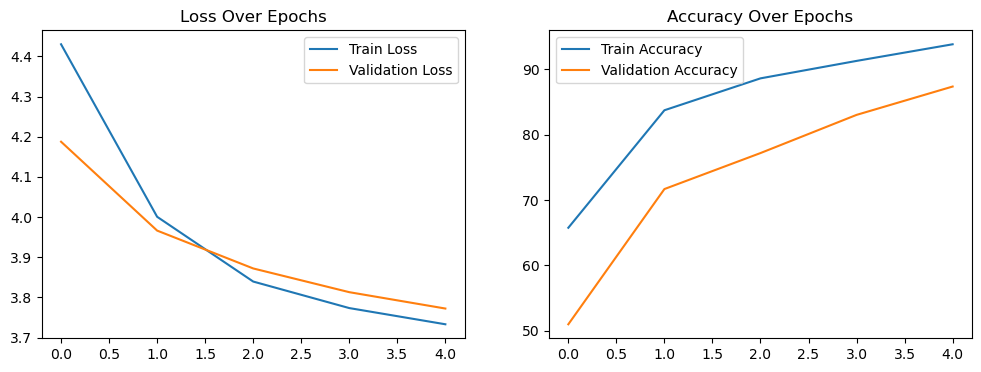

In [28]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.show()

In [29]:
import pandas as pd
from tqdm import tqdm

class CustomTestFolder(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform

        # Get the list of image files
        image_files = sorted(os.listdir(self.root))

        # Create a list of paths to the images in alphabetical order
        self.samples = [os.path.join(self.root, image) for image in image_files]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        image_path = self.samples[index]
        image = Image.open(image_path).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        return image

# Set the directory for the test images
test_data_dir = './test/test/'

# Create a custom dataset for the test set
test_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = CustomTestFolder(root=test_data_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Set the model to evaluation mode
model.eval()

# Create lists to store predictions
predictions = []

# Iterate over the test set and make predictions
for images in tqdm(test_loader, desc="Predicting"):
    with torch.no_grad():
        # Make predictions
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Append predictions to the list
        predictions.extend(predicted.cpu().numpy())

# Create a DataFrame with image file names and predicted labels
image_file_names = [os.path.basename(sample) for sample in test_dataset.samples]
df = pd.DataFrame({'ID': image_file_names, 'Label': predictions})

# Save the DataFrame to a CSV file
df.to_csv('predictions.csv', index=False)

Predicting: 100%|██████████| 32/32 [01:35<00:00,  2.97s/it]
